In [35]:
import argparse
import numpy as np
import mxnet as mx
import data_loader as dl
import module
import os
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from multiprocessing import cpu_count
mx.random.seed(42)
import matplotlib.pyplot as plt

#os.listdir()

In [22]:
def transform(data, label):
    data = data.astype('float32')/255
    return data, label

def shuffle_dataset(X,Y):
    
    '''
        Write code to shuffle the dataset here. 
        
        Args: 
            X: Input feature ndarray
            Y: Input values ndarray
            
        Return:
            X and Y shuffled in place
    
    '''
    r = np.arange(len(X))
    np.random.shuffle(r)
    X = X[r]
    Y = Y[r]
    return (X,Y)
    pass

class DataIterLoader():
    def __init__(self, data_iter):
        self.data_iter = data_iter

    def __iter__(self):
        self.data_iter.reset()
        return self

    def __next__(self):
        batch = self.data_iter.__next__()
        assert len(batch.data) == len(batch.label) == 1
        data = batch.data[0]
        label = batch.label[0]
        return data, label
    


In [23]:
(train_images,train_labels)=dl.DataLoader().load_data('train')
(test_images,test_labels)=dl.DataLoader().load_data('test')
batch_size=32

ntrain=int(0.7*len(train_images))
#Mapping 0-255 intensity scale to 0-1 (without batch normalization)
train_iter = mx.io.NDArrayIter(train_images[:ntrain, :]/255, train_labels[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(train_images[ntrain:, :]/255, train_labels[ntrain:], batch_size)
test_iter = mx.io.NDArrayIter(test_images/255, test_labels, batch_size)

train_loader = DataIterLoader(train_iter)
val_loader = DataIterLoader(val_iter)
test_loader = DataIterLoader(test_iter)

In [24]:
# data_loader=mx.gluon.data.dataset.ArrayDataset(X_train,Y_train)
# train_loader=mx.gluon.data.DataLoader(train_loader, batch_size=5, num_workers=cpu_count())

net1 = nn.HybridSequential()

with net1.name_scope():
    net1.add(
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(512, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(128, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(64, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(32, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(16, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True)
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net1.hybridize()

In [25]:
net2 = nn.HybridSequential()

with net2.name_scope():
    net2.add(
        nn.Dense(1024, activation='relu'),
        nn.Dense(512, activation='relu'),
        nn.Dense(256, activation='relu'),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net2.hybridize()

In [28]:
def neural_net_training(net,trainer,ctx):
    epochs = 10
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    epoch_history = []
    for epoch in range(epochs):
        # training loop (with autograd and trainer steps, etc.)
        cumulative_train_loss = mx.nd.zeros(1, ctx=ctx)
        training_samples = 0
        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = loss_function(output, label)
            loss.backward()
            metric.update(label, output)
            trainer.step(data.shape[0])
            cumulative_train_loss += loss.sum()
            training_samples += data.shape[0]


        train_loss = cumulative_train_loss.asscalar()/training_samples
        train_name, train_acc = metric.get()
        #print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
        metric.reset()

        # validation loop
        cumulative_val_loss = mx.nd.zeros(1, ctx)
        val_samples = 0
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            output = net(data)
            loss = loss_function(output, label)
            cumulative_val_loss += loss.sum()
            val_samples += data.shape[0]
            metric.update(label, output)
        val_loss = cumulative_val_loss.asscalar()/val_samples
        val_name, val_acc = metric.get()
        metric.reset()

        print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}".format(epoch, train_loss, val_loss))
        print("training accuracy: {}, validation accuracy: {}".format(train_acc,val_acc))
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        epoch_history.append(epoch+1)
#     plt.plot(epoch_history, train_loss_history, epoch_history, val_loss_history )
#     plt.title('Loss')
#     plt.show()

#     plt.plot(epoch_history, train_acc_history, epoch_history, val_acc_history )
#     plt.title('Accuracy')
#     plt.show()
    return epoch_history,train_loss_history,val_loss_history,train_acc_history,val_acc_history

    pass

In [29]:
def neural_net_testing(net,ctx):
    cumulative_test_loss = mx.nd.zeros(1, ctx)
    test_samples = 0
    for batch_idx, (data, label) in enumerate(test_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            output = net(data)
            loss = loss_function(output, label)
            cumulative_test_loss += loss.sum()
            test_samples += data.shape[0]
            metric.update(label, output)
    test_loss = cumulative_test_loss.asscalar()/test_samples
    test_name, test_acc = metric.get()
    print("Final testing loss: {:.2f}".format(test_loss))
    print("testing accuracy: {}".format(test_acc))
    pass

In [30]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net1.initialize(mx.init.Uniform(),ctx=ctx,force_reinit=True)
trainer1 = gluon.Trainer(
    params=net1.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history,val_loss_history,train_acc_history,val_acc_history = neural_net_training(net1,trainer1,ctx)
neural_net_testing(net1,ctx)

Epoch 0, training loss: 2.30, validation loss: 2.29
training accuracy: 0.10812547600913938, validation accuracy: 0.0970803730017762
Epoch 1, training loss: 1.50, validation loss: 0.96
training accuracy: 0.4119383092155369, validation accuracy: 0.6388765541740675
Epoch 2, training loss: 0.79, validation loss: 0.68
training accuracy: 0.7026846915460777, validation accuracy: 0.7011545293072824
Epoch 3, training loss: 0.59, validation loss: 0.53
training accuracy: 0.783987052551409, validation accuracy: 0.8195492895204263
Epoch 4, training loss: 0.46, validation loss: 0.45
training accuracy: 0.8327303884234577, validation accuracy: 0.8430284191829485
Epoch 5, training loss: 0.40, validation loss: 0.44
training accuracy: 0.8546506092916984, validation accuracy: 0.8489120781527532
Epoch 6, training loss: 0.37, validation loss: 0.43
training accuracy: 0.8664318354912415, validation accuracy: 0.8541296625222025
Epoch 7, training loss: 0.34, validation loss: 0.41
training accuracy: 0.8752856054

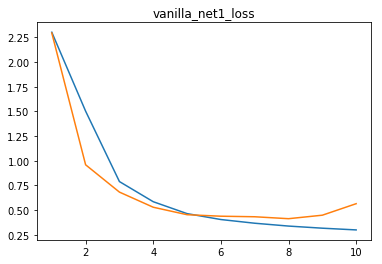

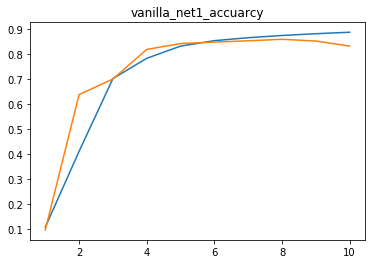

In [31]:
filename='vanilla_net1.params'
net1.save_parameters(filename)
plt.plot(epoch_history, train_loss_history, epoch_history, val_loss_history )
plt.title('vanilla_net1_loss')
plt.savefig('vanilla_net1_loss.png')
plt.show()

plt.plot(epoch_history, train_acc_history, epoch_history, val_acc_history )
plt.title('vanilla_net1_accuarcy')
plt.savefig('vanilla_net1_accuarcy.png')
plt.show()

In [32]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Uniform(),ctx=ctx,force_reinit=True)
trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history,val_loss_history,train_acc_history,val_acc_history = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

Epoch 0, training loss: 0.63, validation loss: 0.46
training accuracy: 0.7757044935262757, validation accuracy: 0.8284302841918295
Epoch 1, training loss: 0.42, validation loss: 0.39
training accuracy: 0.8503189261233816, validation accuracy: 0.8554618117229129
Epoch 2, training loss: 0.37, validation loss: 0.37
training accuracy: 0.8665984386900228, validation accuracy: 0.8648978685612788
Epoch 3, training loss: 0.33, validation loss: 0.36
training accuracy: 0.8771420411271896, validation accuracy: 0.8689498223801065
Epoch 4, training loss: 0.31, validation loss: 0.35
training accuracy: 0.8853055978674791, validation accuracy: 0.8733348134991119
Epoch 5, training loss: 0.29, validation loss: 0.34
training accuracy: 0.8924457349581112, validation accuracy: 0.8766096802841918
Epoch 6, training loss: 0.27, validation loss: 0.33
training accuracy: 0.9001094821020563, validation accuracy: 0.8792184724689165
Epoch 7, training loss: 0.25, validation loss: 0.33
training accuracy: 0.9070354150

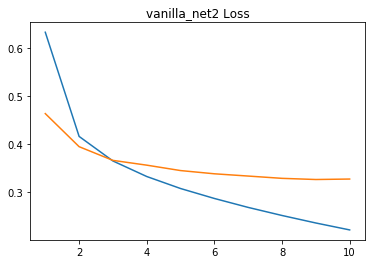

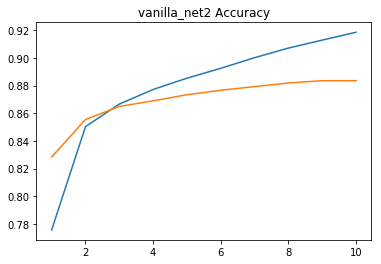

In [37]:
filename='vanilla_net2'
net2.export(filename)
plt.plot(epoch_history, train_loss_history, epoch_history, val_loss_history )
plt.title('vanilla_net2 Loss')
plt.savefig('vanilla_net2_loss.png')
plt.show()

plt.plot(epoch_history, train_acc_history, epoch_history, val_acc_history )
plt.title('vanilla_net2 Accuracy')
plt.savefig('vanilla_net2_accuarcy.png')
plt.show()